<a href="https://colab.research.google.com/github/venom1204/Symbolic-Calculation-Project/blob/main/task___1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install sympy pandas tqdm numpy matplotlib seaborn wordcloud


In [2]:
import sympy as sp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from tqdm import tqdm
from collections import Counter
from sympy.parsing.mathematica import parse_mathematica
import random
import pickle
import matplotlib


In [3]:
matplotlib.rcParams['figure.dpi'] = 150
matplotlib.rcParams['font.size'] = 12

In [4]:
# Configuration
SEED = 42
NUM_SAMPLES = 1000
MAX_DEPTH = 3
TAYLOR_ORDER = 4
sp.init_printing()
sns.set(style="whitegrid", palette="muted")

In [6]:
np.random.seed(SEED)
sp.core.random.seed(SEED)
random.seed(SEED)

In [7]:

# Define symbol
x = sp.symbols('x')

def generate_random_function(depth=0):
    """Generate random mathematical functions with simplified category naming."""
    basic_funcs = [
        (sp.sin, 'trigonometric'),
        (sp.cos, 'trigonometric'),
        (sp.exp, 'exponential'),
        (sp.log, 'logarithmic'),
        (lambda x: 1/(1 + x), 'rational'),
        (lambda x: x**sp.Integer(np.random.randint(1, 4)), 'polynomial')
    ]
    if depth >= MAX_DEPTH:
        return np.random.choice([x, sp.Integer(np.random.randint(1, 5))]), 'atomic'

    operation = np.random.choice(['function', 'add', 'mul', 'div', 'pow'])
    if operation == 'function':
        func, category = random.choice(basic_funcs)
        arg = generate_random_function(depth+1)[0]
        return func(arg), category
    elif operation == 'add':
        a, c1 = generate_random_function(depth+1)
        b, c2 = generate_random_function(depth+1)
        return a + b, 'composite'
    elif operation == 'mul':
        a, c1 = generate_random_function(depth+1)
        b, c2 = generate_random_function(depth+1)
        return a * b, 'composite'
    elif operation == 'div':
        num, c1 = generate_random_function(depth+1)
        den, c2 = generate_random_function(depth+1)
        # Avoid division by zero
        return num / (den + 1), 'composite'
    elif operation == 'pow':
        base, c1 = generate_random_function(depth+1)
        exp = sp.Integer(np.random.randint(2, 4))
        return base**exp, 'composite'

In [8]:
def ast_tokenizer(expr):
    """Tokenize using SymPy's abstract syntax tree"""
    tokens = []
    for node in sp.preorder_traversal(expr):
        if node.is_Atom:
            tokens.append(str(node))
        else:
            tokens.append(node.func.__name__)
    return tokens


In [9]:
def validate_expansion(func, expansion, test_point=0.1, tolerance=1e-6):
    """Validate Taylor expansion by comparing function values at test point"""
    try:
        func_val = float(func.subs(x, test_point).evalf())
        exp_val = float(expansion.subs(x, test_point).evalf())
        return (not np.isnan(func_val) and
                not np.isnan(exp_val) and
                abs(func_val - exp_val) < tolerance)
    except:
        return False

In [10]:
# Additional Mathematica expressions for diversity
mathematica_exprs = [
    "Sin[x]^2 + Cos[x]^3",
    "Exp[x]/(1 + x)",
    "Log[1 + x]^2",
    "Tanh[x]/(1 + x^2)"
]

In [12]:
# Generate dataset
dataset = []
categories = []
print("Generating functions and computing Taylor expansions...")

# SymPy functions
for _ in tqdm(range(NUM_SAMPLES), desc="Generating SymPy Functions"):
    try:
        func, category = generate_random_function()
        # Check if function is well-defined at x=0
        if not func.subs(x, 0).has(sp.nan, sp.oo, sp.zoo, sp.I):
            expansion = sp.series(func, x, 0, TAYLOR_ORDER+1).removeO()

            # Validate expansion
            if validate_expansion(func, expansion):
                dataset.append({
                    'source': 'SymPy',
                    'function': str(func),
                    'function_latex': sp.latex(func),
                    'expansion': str(expansion),
                    'expansion_latex': sp.latex(expansion),
                    'category': category,
                    'tokens': ast_tokenizer(func),
                    'expansion_tokens': ast_tokenizer(expansion),
                    'function_sympy': func,
                    'expansion_sympy': expansion
                })
                categories.append(category)
    except Exception as e:
        continue

Generating functions and computing Taylor expansions...


Generating SymPy Functions: 100%|██████████| 1000/1000 [00:49<00:00, 20.24it/s]


In [13]:
# Process Mathematica expressions
for expr in tqdm(mathematica_exprs, desc="Processing Mathematica"):
    try:
        func = parse_mathematica(expr)
        expansion = sp.series(func, x, 0, TAYLOR_ORDER+1).removeO()

        # Validate expansion
        if validate_expansion(func, expansion):
            dataset.append({
                'source': 'Mathematica',
                'function': expr,
                'function_latex': sp.latex(func),
                'expansion': str(expansion),
                'expansion_latex': sp.latex(expansion),
                'category': 'mathematica',
                'tokens': ast_tokenizer(func),
                'expansion_tokens': ast_tokenizer(expansion),
                'function_sympy': func,
                'expansion_sympy': expansion
            })
            categories.append('mathematica')
    except Exception as e:
        print(f"Error processing {expr}: {e}")


Processing Mathematica: 100%|██████████| 4/4 [00:00<00:00,  5.43it/s]


In [14]:
# Convert to DataFrame for easier analysis
df = pd.DataFrame(dataset)


Generated 512 valid functions with Taylor expansions


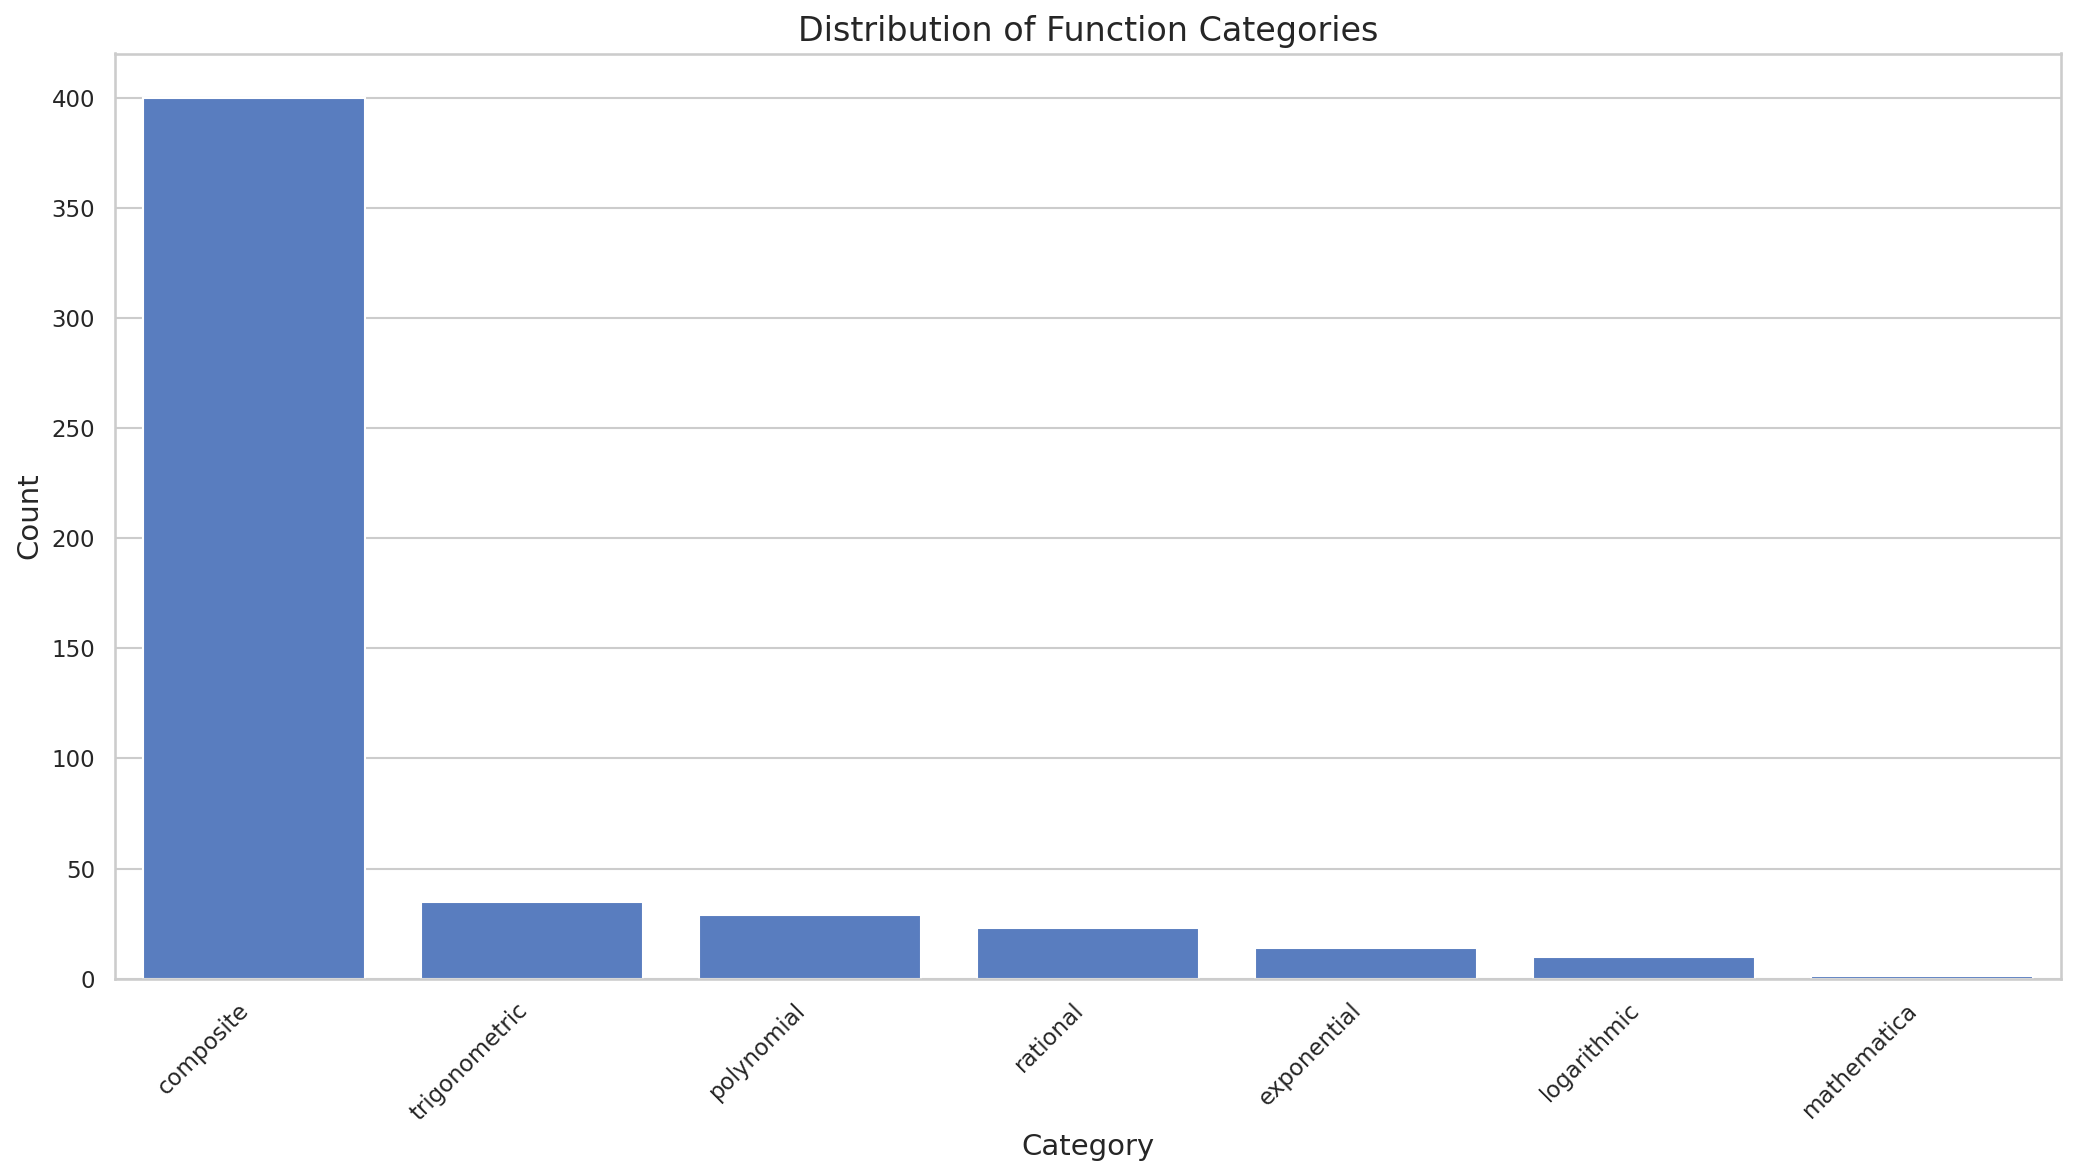

In [15]:
# Visualizations
print(f"Generated {len(df)} valid functions with Taylor expansions")

# 1. Category distribution
plt.figure(figsize=(14, 8))
category_counts = Counter(categories)
top_categories = category_counts.most_common(15)
top_categories_labels, top_categories_values = zip(*top_categories)

sns.barplot(x=list(top_categories_labels), y=list(top_categories_values))
plt.title("Distribution of Function Categories", fontsize=16)
plt.xlabel("Category", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('category_distribution.png', dpi=300)
plt.show()


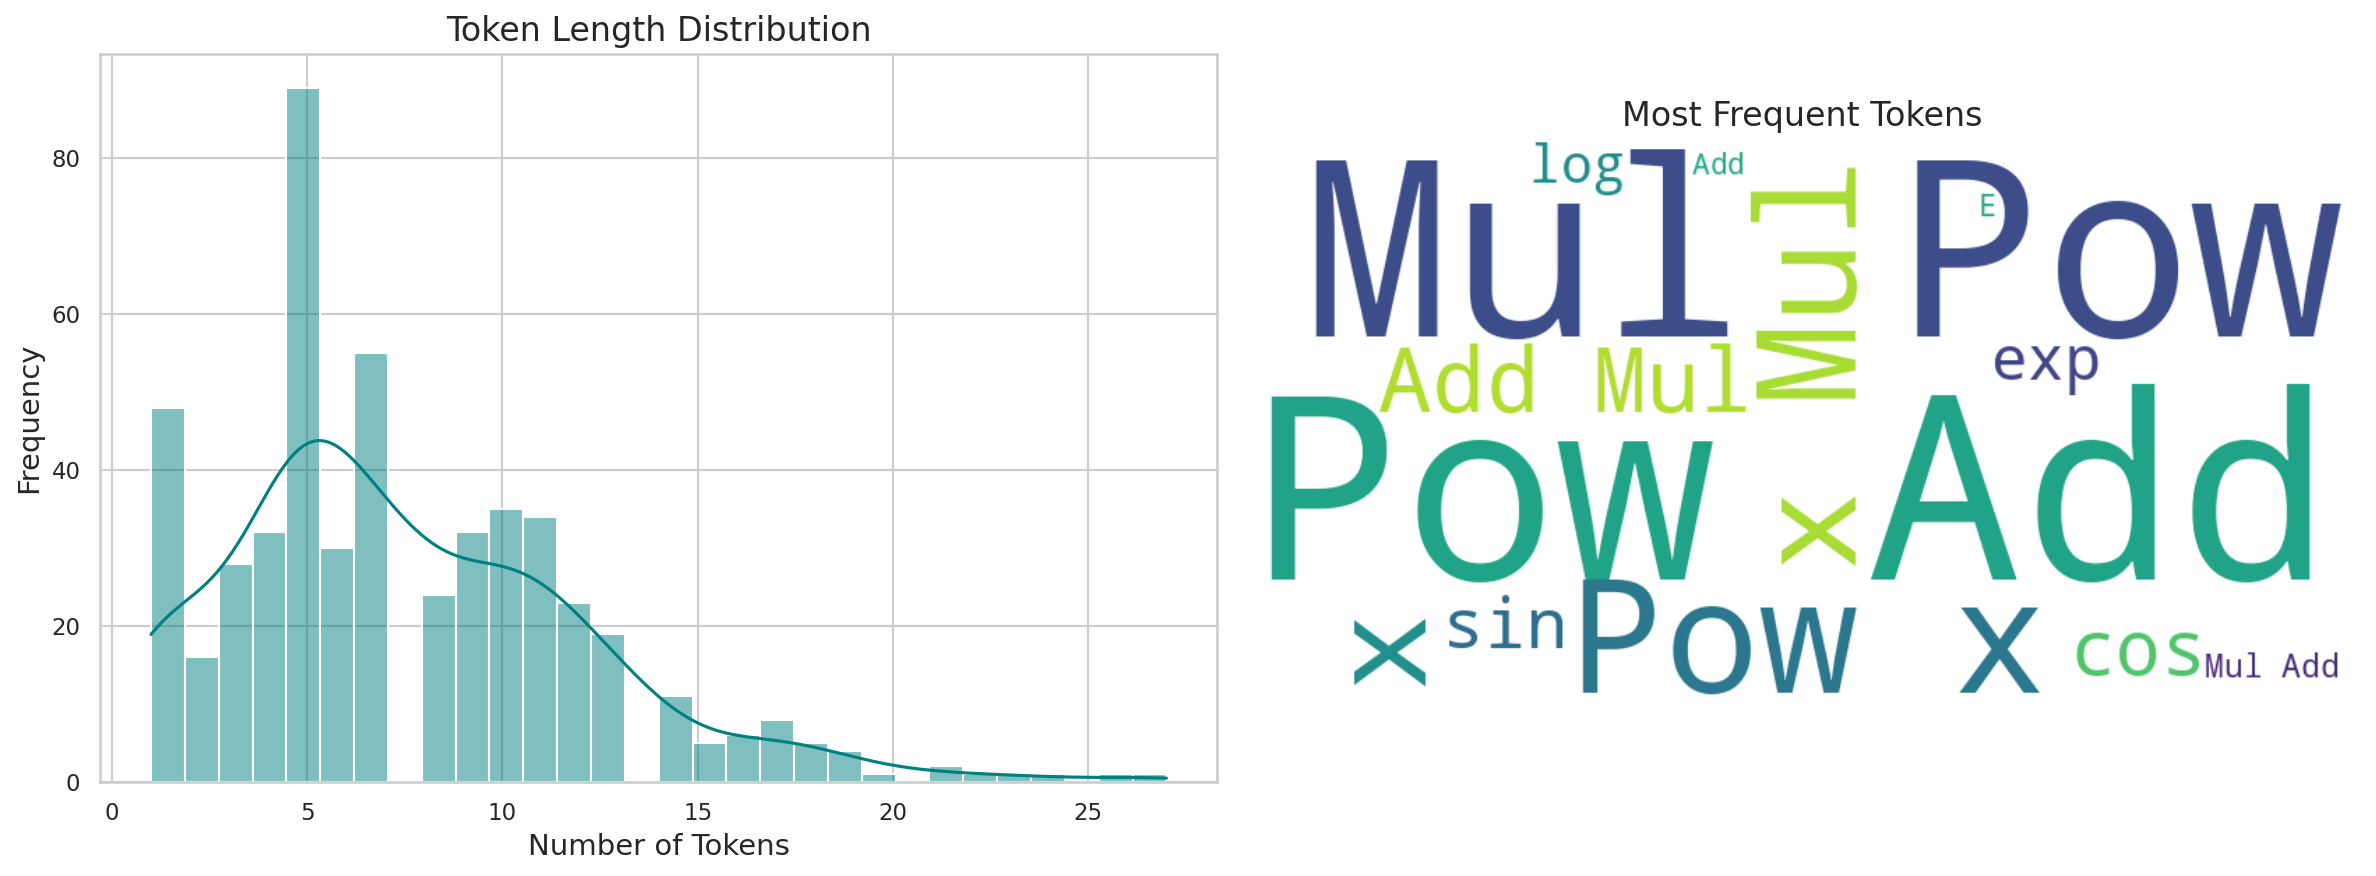

In [16]:
# 2. Token analysis
all_tokens = [token for entry in dataset for token in entry['tokens']]
token_counts = [len(entry['tokens']) for entry in dataset]

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
sns.histplot(token_counts, bins=30, kde=True, color='teal')
plt.title("Token Length Distribution", fontsize=16)
plt.xlabel("Number of Tokens", fontsize=14)
plt.ylabel("Frequency", fontsize=14)

plt.subplot(1, 2, 2)
wordcloud = WordCloud(width=800, height=400, background_color='white',
                     colormap='viridis', max_words=100).generate(' '.join(all_tokens))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Frequent Tokens", fontsize=16)
plt.tight_layout()
plt.savefig('token_analysis.png', dpi=300)
plt.show()

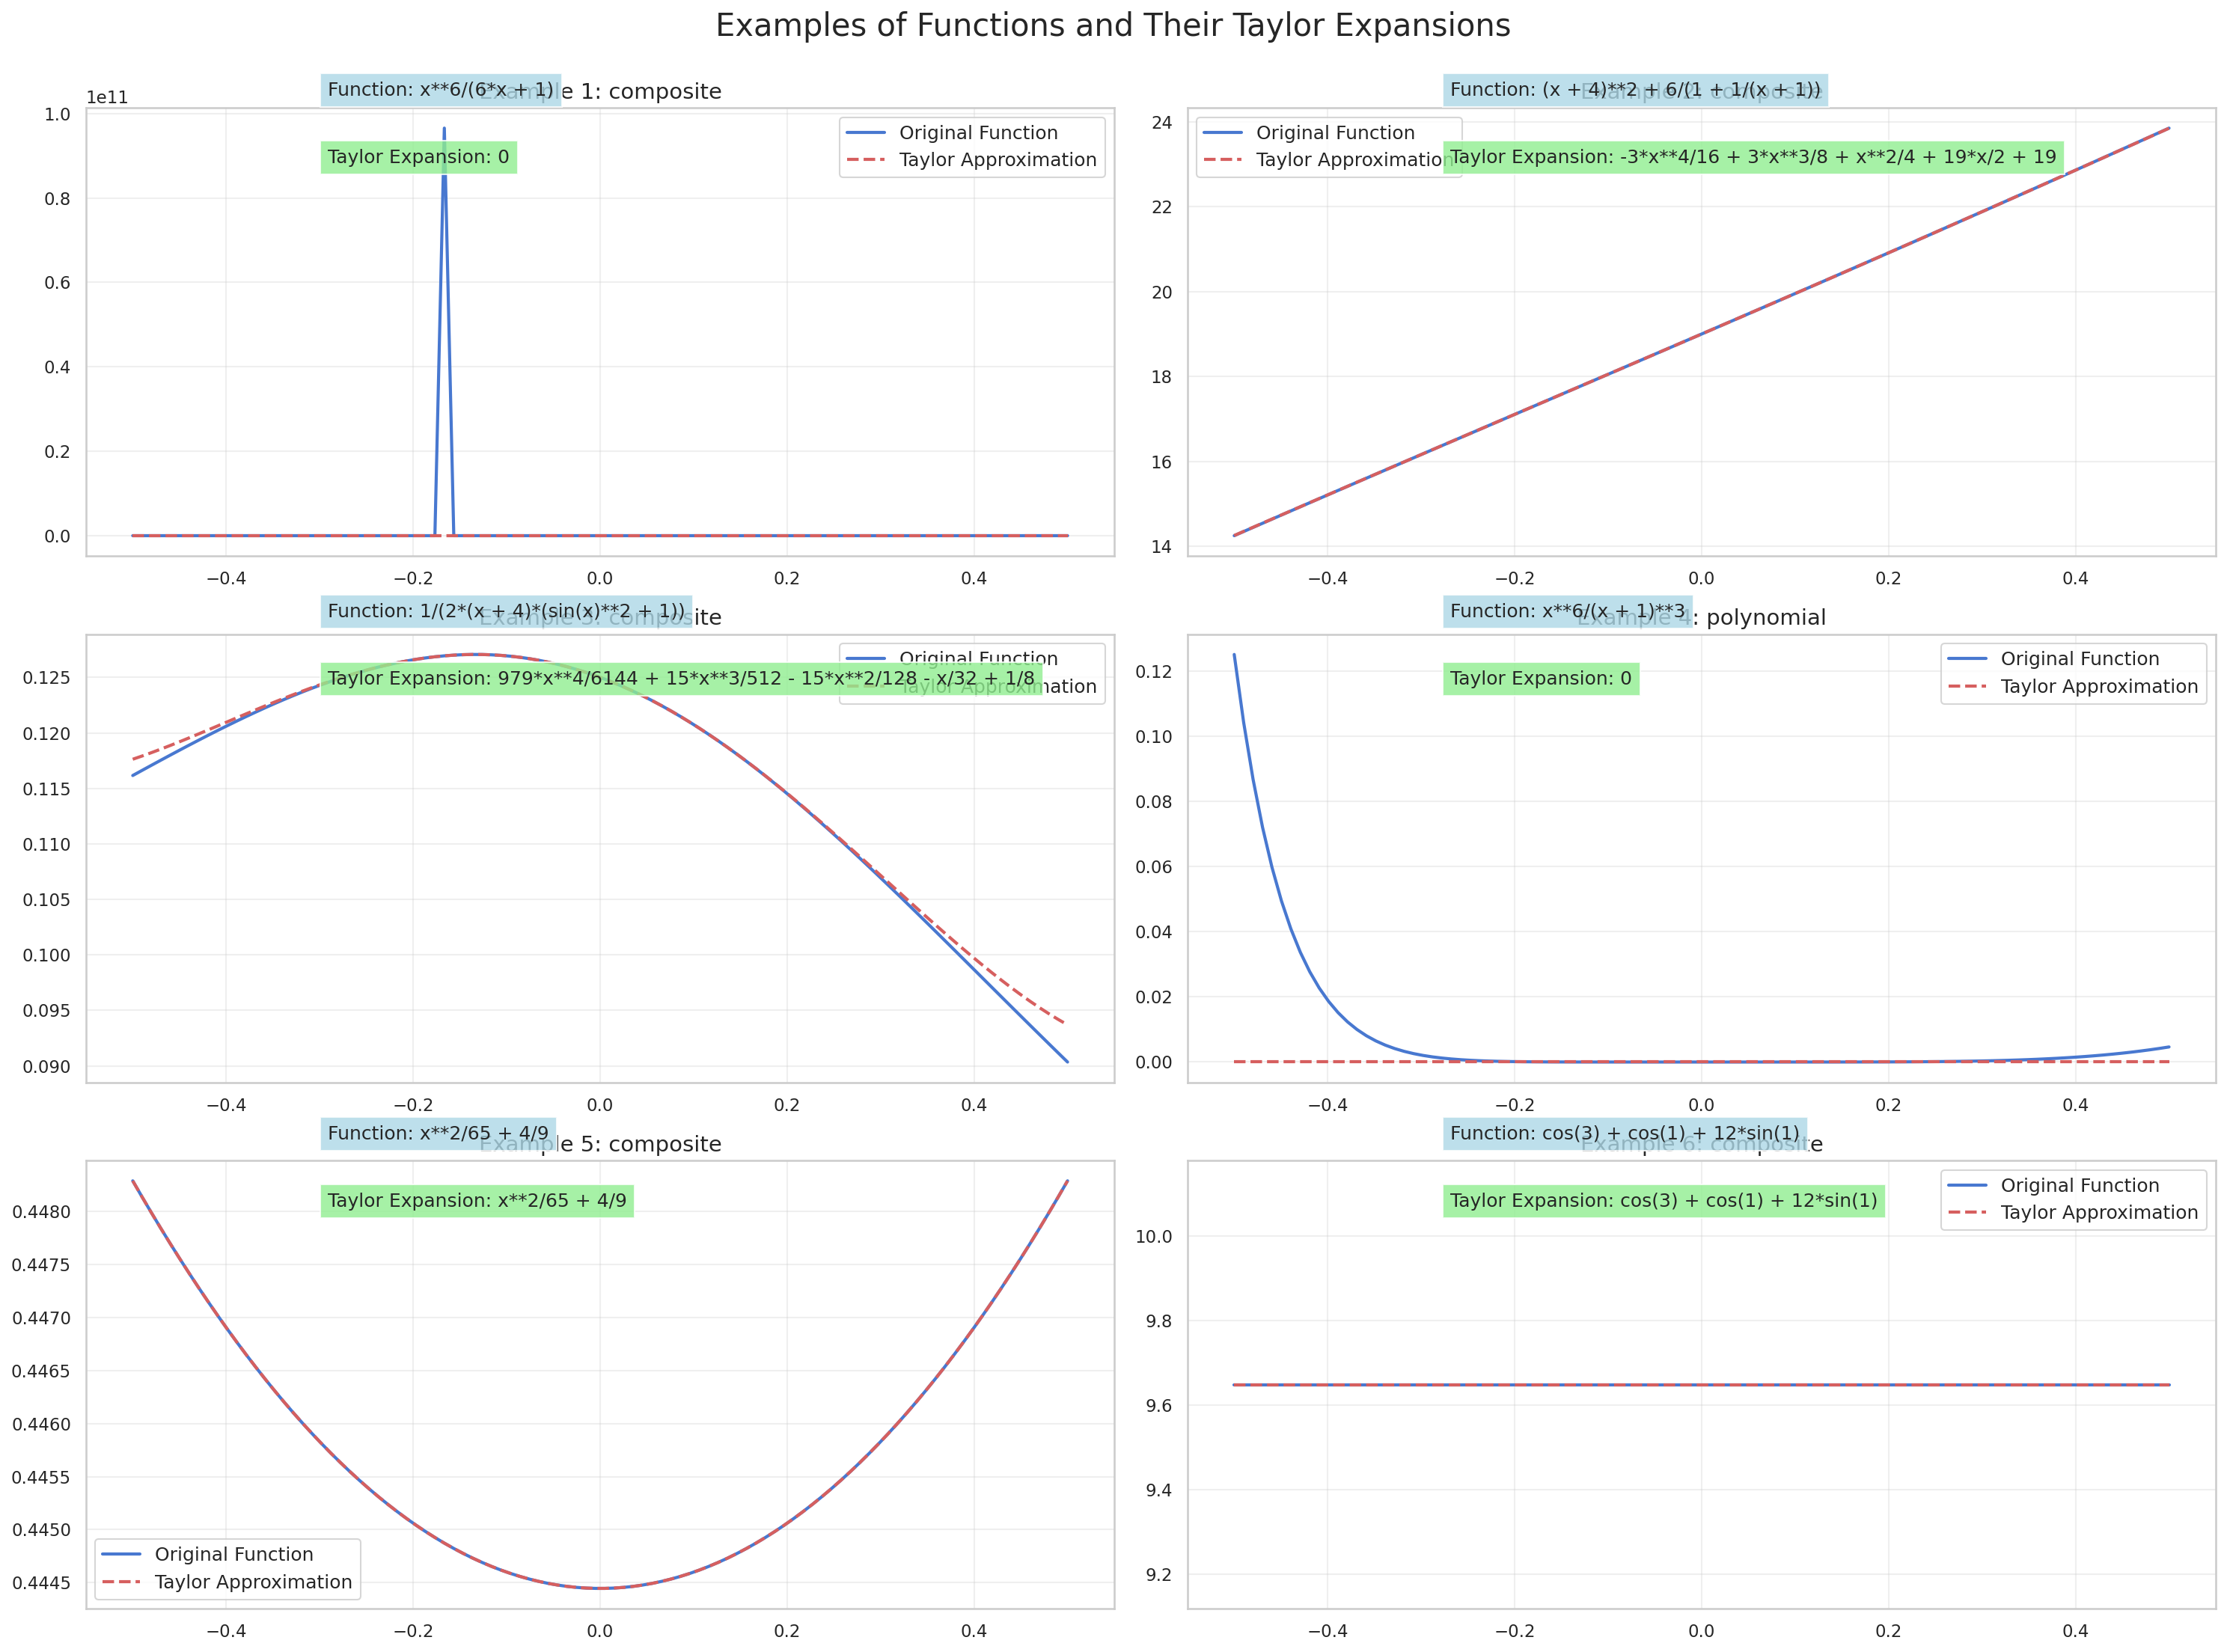

In [17]:
# 3. Visualize Taylor expansions with improved readability
plt.figure(figsize=(20, 15))

for i in range(min(6, len(df))):
    plt.subplot(3, 2, i+1)
    example = df.iloc[i]
    func = example['function_sympy']
    taylor = example['expansion_sympy']

    x_vals = np.linspace(-0.5, 0.5, 100)
    try:
        y_func = [float(func.subs(x, val).evalf()) for val in x_vals]
        y_taylor = [float(taylor.subs(x, val).evalf()) for val in x_vals]

        plt.plot(x_vals, y_func, 'b-', linewidth=2, label='Original Function')
        plt.plot(x_vals, y_taylor, 'r--', linewidth=2, label='Taylor Approximation')
        plt.title(f"Example {i+1}: {example['category']}", fontsize=14)
        plt.grid(True, alpha=0.3)
        plt.legend(fontsize=12)

        # Add text boxes with clear function and expansion
        func_text = example['function']
        exp_text = example['expansion']

        # Create separate text box for function and expansion
        plt.figtext(0.15 + (i%2)*0.5, 0.93 - (i//2)*0.31,
                   f"Function: {func_text}",
                   ha="left", fontsize=12,
                   bbox={"facecolor":"lightblue", "alpha":0.8, "pad":5})

        plt.figtext(0.15 + (i%2)*0.5, 0.89 - (i//2)*0.31,
                   f"Taylor Expansion: {exp_text}",
                   ha="left", fontsize=12,
                   bbox={"facecolor":"lightgreen", "alpha":0.8, "pad":5})

    except:
        plt.text(0, 0, "Cannot plot this function", ha='center', va='center', fontsize=14)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.suptitle("Examples of Functions and Their Taylor Expansions", fontsize=20)
plt.savefig('taylor_expansions.png', dpi=300, bbox_inches='tight')
plt.show()

In [18]:
# 4. Print examples of functions and their Taylor expansions
print("\nExamples of Functions and Their Taylor Expansions:")
for i in range(min(5, len(df))):
    example = df.iloc[i]
    print(f"\nExample {i+1} ({example['category']}):")
    print(f"Function: {example['function']}")
    print(f"Taylor Expansion: {example['expansion']}")



Examples of Functions and Their Taylor Expansions:

Example 1 (composite):
Function: x**6/(6*x + 1)
Taylor Expansion: 0

Example 2 (composite):
Function: (x + 4)**2 + 6/(1 + 1/(x + 1))
Taylor Expansion: -3*x**4/16 + 3*x**3/8 + x**2/4 + 19*x/2 + 19

Example 3 (composite):
Function: 1/(2*(x + 4)*(sin(x)**2 + 1))
Taylor Expansion: 979*x**4/6144 + 15*x**3/512 - 15*x**2/128 - x/32 + 1/8

Example 4 (polynomial):
Function: x**6/(x + 1)**3
Taylor Expansion: 0

Example 5 (composite):
Function: x**2/65 + 4/9
Taylor Expansion: x**2/65 + 4/9


In [19]:
# Create vocabulary and tokenize dataset
all_tokens = []
for entry in dataset:
    all_tokens.extend(entry['tokens'])
    all_tokens.extend(entry['expansion_tokens'])

# Build vocabulary with special tokens
vocab = ['<pad>', '<sos>', '<eos>', '<unk>'] + sorted(list(set(all_tokens)))
token_to_id = {token: idx for idx, token in enumerate(vocab)}
id_to_token = {idx: token for token, idx in token_to_id.items()}

# Save processed dataset and vocabulary
with open('symbolic_dataset.pkl', 'wb') as f:
    pickle.dump({
        'dataset': dataset,
        'vocab': vocab,
        'token_to_id': token_to_id,
        'id_to_token': id_to_token
    }, f)

print(f"\nDataset saved with {len(dataset)} entries and vocabulary size {len(vocab)}")


Dataset saved with 512 entries and vocabulary size 496
